In [1]:
import numpy as np
import therpy as tp
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
twopi = 2 * np.pi
import ipywidgets
from tqdm import tqdm_notebook as tqdm

The servers are not connected!
Using the local database copy. Could be outdated!
Internal Structure of therpy has changed.
Now all functions (except for helper functions and imageio functions) are stored at one place therpy.funcs and available on root as tp.####.
If there are errors in your program, simply replace tp.module_name.func_name to tp.func_name.
If some function is not present there, it must be a helper function and can be accessed via tp.funcs._____
If you would like to go back to old therpy, use pip install therpy==0.2.5 


# Cavity Mode Sum

In [2]:
# Function Definitions 
def step(x, x0):
    if x <= x0: return 0.0
    else: return 1.0
def istep(x, x0):
    if x >= x0: return 0.0
    else: return 1.0

step = np.vectorize(step, excluded='x0')
istep = np.vectorize(istep, excluded='x0')

def evens(x, t, n, T, G, L, k, w, c):
    return (t > n*T) * np.exp(- n * G * L) * np.exp(-G * x) * np.sin(k * x - w * (t - n * T)) * istep(x, c * (t - n * T))
def odds(x, t, n, T, G, L, k, w, c):
    return -1 * (t > n*T) * np.exp(- n * G * L) * np.exp(-G * (L - x)) * np.sin(- k * (x - L) - w * (t - n * T)) * step(x, L - c * (t - n * T))
def response(x, t, c=1, L=1, wl=1, dl=5, n=None):
    T = L/c
    k = twopi / wl
    w = twopi * c / wl
    G = 1.0 / dl
    if n is None: n = int(float(t) / T) + 1
    return np.sum([evens(x, t, ni, T, G, L, k, w, c) for ni in range(0, n, 2)], axis=0) + np.sum([odds(x, t, ni, T, G, L, k, w, c) for ni in range(1, n, 2)], axis=0)
def response_density(x, t, c=1, L=1, wl=1, dl=5, n=None):
    return np.diff(response(x, t, c=c, L=L, wl=wl, dl=dl, n=n))

## Time Evolution

In [3]:
# Animate the build up 
c0 = 1.0
L = 1.0
wl0 = L / 3
dl0 = 4 * L

x = np.linspace(0.0, 1.0, 100)
def temp(t = 0.0):
    plt.plot(x, response(x, t, c0, L, wl0, dl0))
    plt.ylim([-10, 10])
    plt.xlim([0, 1])
    plt.show()
ip = ipywidgets.interact(temp,t=(0, 10.0, 0.01))

In [4]:
# Sonogram 
c = 15e-3
L = 100e-6
xlist = np.linspace(0, L, 100)
wl = 2 * L / 2
f = c / wl
omega = twopi * f
Ncycles = np.arange(0, 10, 0.02)
Gamma = omega / 20
tlist = Ncycles / f
dl = 2 * c / Gamma

movie = np.array([response_density(x=xlist, t=tlist[i], c=c, L=L, wl=wl, dl=dl) for i in tqdm(range(len(tlist)))]).T

# Fourier Transform 
klist = np.arange(0, 8 * twopi/L, 0.1 * twopi/L)
ft = np.array([tp.fourier_transform(xlist[1:], movie[:,i], klist)[1] for i in tqdm(range(len(tlist)))]).T

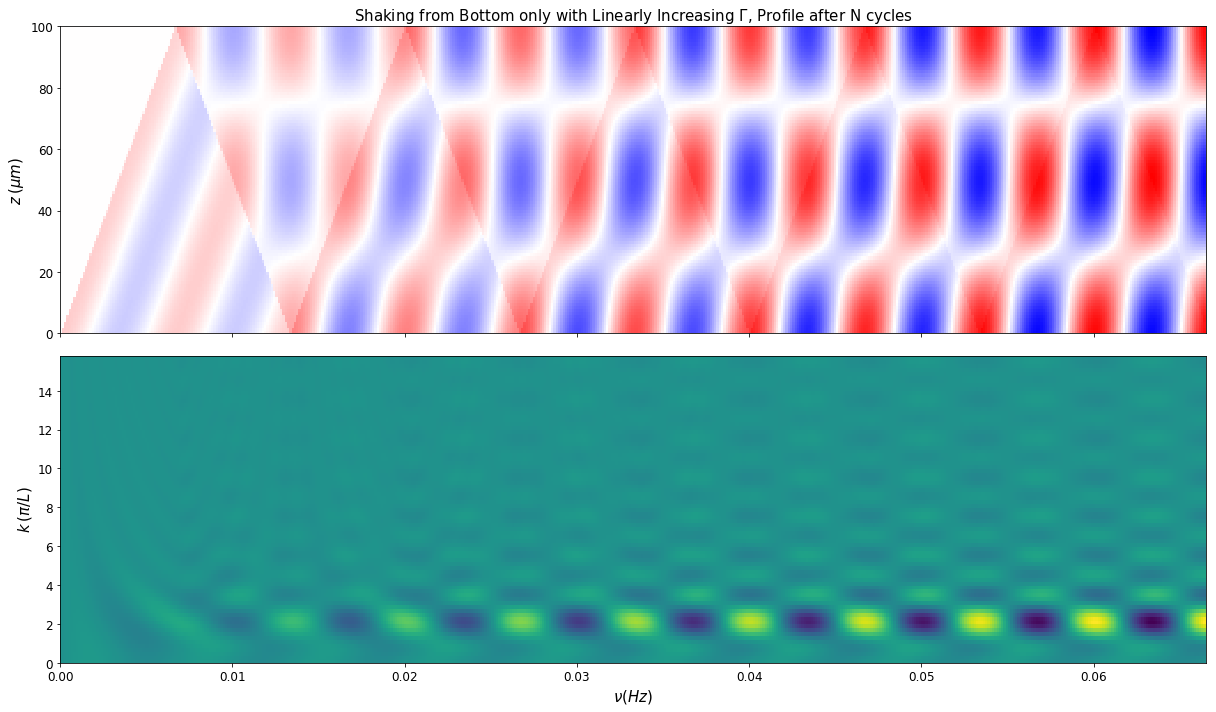

In [5]:
# Figure 
fig, ax = plt.subplots(figsize=[17, 10], sharex=True, nrows=2)
plt.sca(ax[0])
clim = np.max(np.abs(movie))
plt.pcolor(tlist, xlist*1e6, movie, cmap='bwr', vmin=-clim, vmax=clim)
plt.title(r'Shaking from Bottom only with Linearly Increasing $\Gamma$, Profile after N cycles', fontsize=15)
plt.ylabel(r'$z \: (\mu m)$', fontsize=15)
plt.yticks(fontsize=12)
plt.sca(ax[1])
plt.pcolor(tlist, klist / (np.pi/L), np.real(ft),)
plt.xlabel(r'$\nu (Hz)$', fontsize=15)
plt.ylabel(r'$k \: (\pi/L)$', fontsize=15)
plt.xlim([0, None])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

## Sonogram vs Freq

In [13]:
# Sonogram 
c = 15e-3
L = 100e-6
xlist = np.linspace(0, L, 100)
flist = np.arange(2.5, 1000, 2.5)
Ncycles = 25
Gamma = flist / 1000 * 500 * 2

tlist = Ncycles / flist
dl = 2 * c / Gamma
wl = c / flist

movie = np.array([response_density(x=xlist, t=tlist[i], c=c, L=L, wl=wl[i], dl=dl[i]) for i in tqdm(range(len(flist)))]).T

# Fourier Transform 
klist = np.arange(0, 8 * twopi/L, 0.5 * twopi/L)
ft = np.array([tp.fourier_transform(xlist[1:], movie[:,i], klist)[1] for i in tqdm(range(len(flist)))]).T

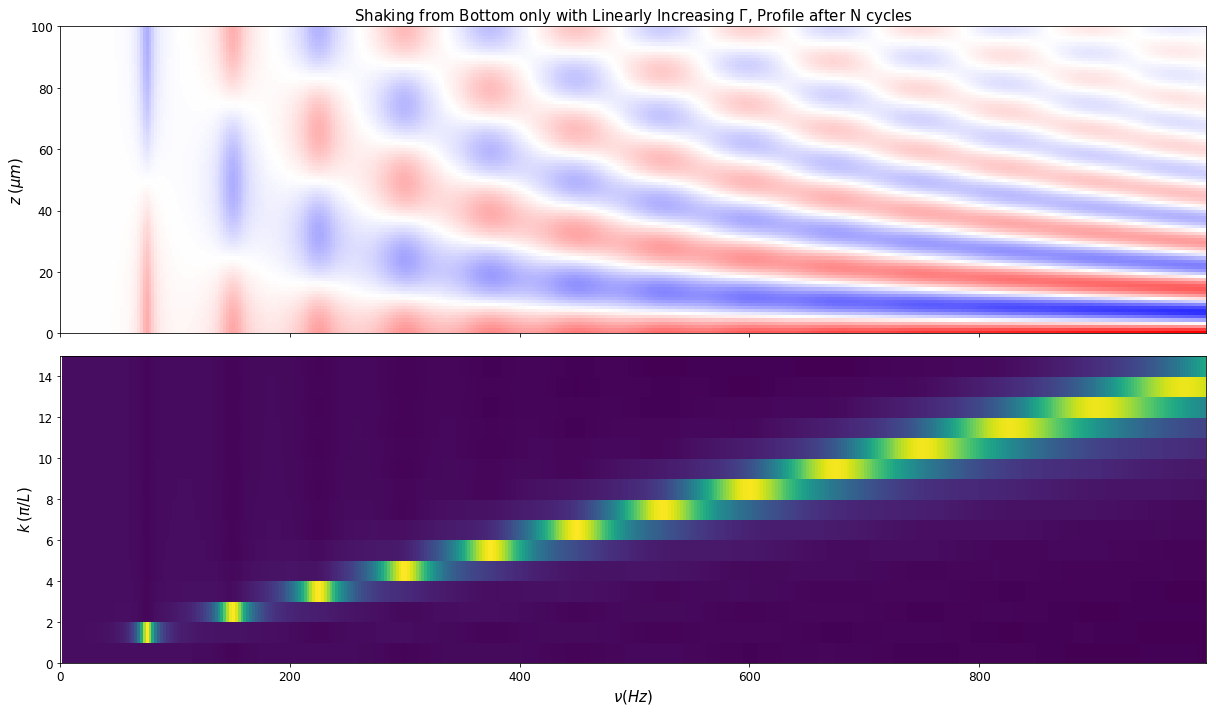

In [14]:
# Figure 
fig, ax = plt.subplots(figsize=[17, 10], sharex=True, nrows=2)
plt.sca(ax[0])
clim = np.max(np.abs(movie))
plt.pcolor(flist, xlist*1e6, movie, cmap='bwr', vmin=-clim, vmax=clim)
plt.title(r'Shaking from Bottom only with Linearly Increasing $\Gamma$, Profile after N cycles', fontsize=15)
plt.ylabel(r'$z \: (\mu m)$', fontsize=15)
plt.yticks(fontsize=12)
plt.sca(ax[1])
plt.pcolor(flist, klist / (np.pi/L), np.real(ft),)
plt.xlabel(r'$\nu (Hz)$', fontsize=15)
plt.ylabel(r'$k \: (\pi/L)$', fontsize=15)
plt.xlim([0, None])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [15]:
# Fourier Widths 
mode_num = np.arange(1, 13, 1)
lorentzian_fits = []
res_freq = 75

for m in mode_num: 
    guess = dict(x0 = [75 * m, 'Hz'], gamma = [0.25 * 75 * m, 'Hz'], amp=1, offset=0)
    cf = tp.curve_fit(tp.lorentzian, guess, flist, np.real(ft[m, :]), plot=False, info=False)
    lorentzian_fits.append(cf)

plt.figure()
plt.plot([f['x0'] for f in lorentzian_fits], [abs(f['gamma']*twopi) for f in lorentzian_fits])
plt.plot(flist, Gamma)

def temp(test=1):
    lorentzian_fits[test-1].plot()
    plt.show()

ipywidgets.interact(temp, test=(1, len(mode_num)))

<function __main__.temp>

In [16]:
# Fourier Widths 
mode_num = np.arange(1, 13, 1)
lorentzian_fits = []
res_freq = 75

for m in mode_num: 
    guess = dict(x0 = [75 * m, 'Hz'], gamma = [0.25 * 75 * m, 'Hz'], amp=1, offset=0)
    cf = tp.curve_fit(tp.lorentzian, guess, flist, flist * np.real(ft[m, :]), plot=False, info=False)
    lorentzian_fits.append(cf)

plt.figure()
plt.plot([f['x0'] for f in lorentzian_fits], [abs(f['gamma']*twopi) for f in lorentzian_fits])
plt.plot(flist, Gamma)

def temp(test=1):
    lorentzian_fits[test-1].plot()
    plt.show()

ipywidgets.interact(temp, test=(1, len(mode_num)))

<function __main__.temp>